# Assignment 2: EN4553-Deep Learning for Vision
## Question 3 part (b) and (c)
### Index No: 200041E, 200087A, 200285E, 200505G

In [1]:
from urllib.request import urlretrieve
import os
import tarfile
import cv2
import numpy as np
import pprint
import operator
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from keras.applications.inception_v3 import InceptionV3

import sys

import zipfile
from tqdm import tqdm
import tensorflow as tf
import random
from scipy.ndimage import zoom
import shutil
from sklearn.neighbors import KNeighborsClassifier

In [1]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi       673Mi        24Gi       0.0Ki       6.2Gi        30Gi
Swap:             0B          0B          0B


## Download the dataset

In [5]:
URL_CALTECH_101_DATA = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip'

def download_dataset(url):
    current_directory = os.path.dirname(os.path.realpath('__file__'))
    dataset_file_path = current_directory+"/dataset.zip"
    if os.path.exists(dataset_file_path):
        print("Already downloaded.")
    else:
        filename, headers = urlretrieve(url, dataset_file_path)
    print("Done")

download_dataset(URL_CALTECH_101_DATA)

Done


In [6]:
def extract_dataset(dataset_file_path, extraction_directory):
    if not os.path.exists(extraction_directory):
        os.makedirs(extraction_directory)

    if dataset_file_path.endswith(".zip"):
        with zipfile.ZipFile(dataset_file_path, "r") as zip_ref:
            zip_ref.extractall(extraction_directory)
        print("Extraction complete.")
    else:
        print("Error: Unsupported file type. Only .zip files are supported.")

extract_dataset('/kaggle/working/dataset.zip', '/kaggle/working/data')

Extraction complete.


In [7]:
def extract_tar_files(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("Done")

In [8]:
os.makedirs("/kaggle/working/caltec")

In [9]:
extract_tar_files("/kaggle/working/data/caltech-101/101_ObjectCategories.tar.gz", "/kaggle/working/caltec/")

Done


In [10]:
extract_tar_files("/kaggle/working/data/caltech-101/Annotations.tar", "/kaggle/working/caltec/")

Done


## Exploring dataset

In [2]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found.")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [3]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

#### Number of classes

In [13]:
len(return_images_per_category('./caltec'))

102

## Creating Dataset with data augmentations (Horizontal flipping, randomly zoom, Gaussian Blur, Rotating)

In [14]:
total_count = 0
for category,count in return_images_per_category('./caltec'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8677


In [4]:
def random_zoom(img, zoom_range=(0.8, 1.2)):
    """Zooms the image randomly within the specified zoom_range."""
    zoom_factor = random.uniform(*zoom_range)
    height, width, channels = img.shape
    # Zoom on the image (keeping the channels intact)
    zoomed_img = zoom(img, (zoom_factor, zoom_factor, 1), order=1)
    
    # Crop or pad back to the original size
    if zoom_factor > 1:
        # If zoomed in, we need to crop the image
        start_h = (zoomed_img.shape[0] - height) // 2
        start_w = (zoomed_img.shape[1] - width) // 2
        zoomed_img = zoomed_img[start_h:start_h+height, start_w:start_w+width]
    else:
        # If zoomed out, we need to pad the image
        pad_h = (height - zoomed_img.shape[0]) // 2
        pad_w = (width - zoomed_img.shape[1]) // 2
        zoomed_img = np.pad(zoomed_img, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)

    return zoomed_img

In [5]:
def random_rotation(image, angle_range=(-15, 15)):
    """Applies a random rotation to the input image within a specified angle range."""
    h, w = image.shape[:2]
    angle = random.uniform(*angle_range)  # Generate a random angle within the range
    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    rotated_img = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_img

In [6]:
# Set a random seed for reproducibility
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

def create_original_data(data_directory):
    X = []
    Y = []

    print("Preparing X and Y for dataset...")

    categories = return_images_per_category(data_directory)

    for category, _ in tqdm(categories, desc="Processing categories", unit="category"):
        if category == 'BACKGROUND_Google':
            continue

        images = get_images(category, data_directory)

        for image in images:
            if not image.endswith('.jpg'):
                continue

            img = read_image(image)

            # Add original image
            X.append(img)
            Y.append(category)

    X = np.array(X, dtype=np.uint8)
    Y = np.array(Y)
    print("\nOriginal datasets constructed")
    return X, Y

def split_dataset(X, Y, test_size=0.33, random_state=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, Testing labels shape: {Y_test.shape}")
    return X_train, X_test, Y_train, Y_test

def augment_data(X, Y):
    augmented_X = []
    augmented_Y = []

    for img, label in zip(X, Y):
        # Add original image
        augmented_X.append(img)
        augmented_Y.append(label)

        # Add horizontally flipped image
        if random.random() < 0.3:
            flipped_img = np.fliplr(img)
            augmented_X.append(flipped_img)
            augmented_Y.append(label)

        # Add randomly zoomed image
        if random.random() > 0.6:
            zoomed_img = random_zoom(img, zoom_range=(1.05, 1.2))
            augmented_X.append(zoomed_img)
            augmented_Y.append(label)

        # Add random Gaussian blurred image
        if random.random() > 0.7 and random.random() < 0.8:
            kernel_size = random.choice([(3, 3), (5, 5)])
            blurred_img = cv2.GaussianBlur(img, kernel_size, 0)
            augmented_X.append(blurred_img)
            augmented_Y.append(label)

        # Add randomly rotated image
        if random.random() > 0.3 and random.random() < 0.6:
            rotated_img = random_rotation(img, angle_range=(-15, 15))
            augmented_X.append(rotated_img)
            augmented_Y.append(label)

    augmented_X = np.array(augmented_X, dtype=np.uint8)
    augmented_Y = np.array(augmented_Y)
    print("\nData augmentation completed")
    return augmented_X, augmented_Y

# Main function to call the above functions
def create_training_data(data_directory, seed=42):
    set_random_seed(seed)  # Set random seed for reproducibility
    X, Y = create_original_data(data_directory)
    X_train, X_test, Y_train, Y_test = split_dataset(X, Y, random_state=seed)
    X_train_augmented, Y_train_augmented = augment_data(X_train, Y_train)
    
    return X_train_augmented, Y_train_augmented, X_test, Y_test


In [19]:
# first time > 0.6
# < 0.3
# > 0.2 & < 0.4
# < 0.2

# second time < 0.3
# > 0.6
# > 0.7 & 0.8 >
# > 0.3 & < 0.6

X_train, Y_train, X_test, Y_test = create_training_data('/kaggle/working/caltec')

Preparing X and Y for dataset...


Processing categories: 100%|██████████| 102/102 [00:10<00:00, 10.11category/s]



Original datasets constructed
Training data shape: (5813, 200, 300, 3), Training labels shape: (5813,)
Testing data shape: (2864, 200, 300, 3), Testing labels shape: (2864,)

Data augmentation completed


In [44]:
X_train.shape

(13631, 200, 300, 3)

In [45]:
Y_train[1001]

'Faces_easy'

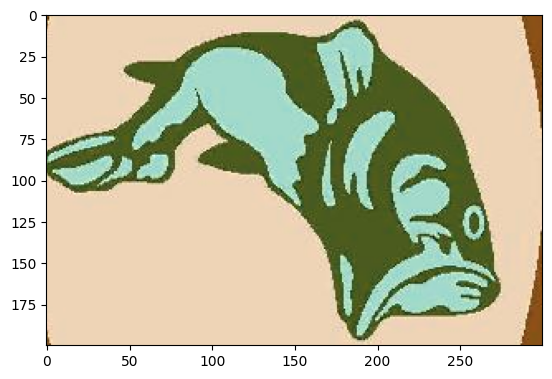

In [23]:
imshow(X_train[1001])

### Making one-hot encoded labels

In [20]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y_train)
Y_integer_encoded_test = label_encoder.fit_transform(Y_test)

In [26]:
len(Y_integer_encoded)

12916

In [21]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot_test = to_categorical(Y_integer_encoded_test)

In [28]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['umbrella'], dtype='<U15')

### Basic Normalization

In [22]:
X_normalized_test = X_test.astype(np.float16) / 255

In [10]:
X_normalized = X_train.astype(np.float16) / 255

In [23]:
# We wouldn't require X anymore, so, let's free up some memory
del X_train
del Y_train
del Y_integer_encoded
del Y_integer_encoded_test

### Splitting the Data

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_normalized, Y_one_hot, test_size=0.2, random_state=42)

In [13]:
del X_normalized

In [33]:
Y_train.shape

(10332, 101)

# 3) b) Using InceptionV3 by freezing feature extractor layers

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(101, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)
transfer_learning_model.summary()

In [32]:
#We freeze the model excepted the added layers

for layer in transfer_learning_model.layers[:280]:
    layer.trainable = False
for layer in transfer_learning_model.layers[280:]:
    layer.trainable = True

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
callbacks = [ModelCheckpoint('transfer_learning_weights.keras', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
transfer_learning_model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_val,Y_val), callbacks=callbacks)

Epoch 1/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 80s 365ms/step - accuracy: 0.4219 - loss: 2.7230 - val_accuracy: 0.8783 - val_loss: 0.4829

Epoch 2/15

  1/137 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.9062 - loss: 0.4649

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.

  self._save_model(epoch=epoch, batch=None, logs=logs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.8747 - loss: 0.5119 - val_accuracy: 0.9127 - val_loss: 0.3597

Epoch 3/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.9425 - loss: 0.2007 - val_accuracy: 0.9085 - val_loss: 0.3565

Epoch 4/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9506 - loss: 0.1855 - val_accuracy: 0.9237 - val_loss: 0.3030

Epoch 5/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9732 - loss: 0.0831 - val_accuracy: 0.9161 - val_loss: 0.3671

Epoch 6/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9773 - loss: 0.0658 - val_accuracy: 0.9195 - val_loss: 0.3578

Epoch 7/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9867 - loss: 0.0495 - val_accuracy: 0.9195 - val_loss: 0.3996

Epoch 8/15

137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9900 - loss: 0.0432 - val_accuracy: 0.9230 - val_loss: 0.3935

Epoch 8: early stopping


In [23]:
transfer_learning_model.save('/content/drive/MyDrive/caltec_assignment/transfer_learning_model.h5')

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
del X_train
del X_val

#### Accuracy of the model when freezing below layers

In [15]:
# Evaluate the model on the test set
model = load_model('/content/drive/MyDrive/caltec_assignment/transfer_learning_model.h5')

test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9135 - loss: 0.4928

Test Loss: 0.3943

Test Accuracy: 0.9270


# 3) c) Train all Inception-V3 model layers

In [34]:
base_model = InceptionV3(weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(101, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [37]:
# delete X_test, and Y_test for free up memory
del X_test
del Y_test

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
callbacks = [ModelCheckpoint('/kaggle/working/transfer_learning_weights.keras', monitor='val_acc', save_best_only=True)]
transfer_learning_model.fit(X_train, Y_train, batch_size=16, epochs=30, verbose=1, validation_data=(X_val,Y_val), callbacks=callbacks)

Epoch 1/30


I0000 00:00:1729255324.254082     231 service.cc:145] XLA service 0x7ea82c006b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729255324.254139     231 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/646 ━━━━━━━━━━━━━━━━━━━━ 13:41:06 76s/step - accuracy: 0.0000e+00 - loss: 4.8915

I0000 00:00:1729255365.354895     231 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


646/646 ━━━━━━━━━━━━━━━━━━━━ 196s 186ms/step - accuracy: 0.2204 - loss: 3.7611 - val_accuracy: 0.2945 - val_loss: 3.5064
Epoch 2/30
  1/646 ━━━━━━━━━━━━━━━━━━━━ 1:28 137ms/step - accuracy: 0.2500 - loss: 3.5026

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.3277 - loss: 3.1084 - val_accuracy: 0.2864 - val_loss: 3.4097
Epoch 3/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.3717 - loss: 2.7417 - val_accuracy: 0.3603 - val_loss: 3.0017
Epoch 4/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 106ms/step - accuracy: 0.4197 - loss: 2.4723 - val_accuracy: 0.4454 - val_loss: 2.2086
Epoch 5/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.4577 - loss: 2.1546 - val_accuracy: 0.3359 - val_loss: 3.4444
Epoch 6/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 106ms/step - accuracy: 0.4861 - loss: 2.0829 - val_accuracy: 0.4965 - val_loss: 2.6063
Epoch 7/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.5449 - loss: 1.7376 - val_accuracy: 0.5743 - val_loss: 1.7165
Epoch 8/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.5886 - loss: 1.5385 - val_accuracy: 0.6006 - val_loss: 1.5175
Epoch 9/30
646/646 ━━━━━━━━━━━━━━━━━━━━ 68s 105ms/step - accuracy: 0.6283 - loss: 1.3363 - val

In [40]:
transfer_learning_model.save('/kaggle/working/inception_full_epoch30_1.h5')

#### Accuracy of the model in the middle of the training procedure

In [26]:
test_loss, test_accuracy = transfer_learning_model.evaluate(X_test, Y_test, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.6747 - loss: 2.1521
Test Loss: 2.1526
Test Accuracy: 0.6721


## Retrain with Different Augmentation Combinations

### I could not train the entire combinations together due to limited RAM memory. I tried using a custom data loader to load the data samples into memory in batches for training the model, but this consumed a significant amount of time. Therefore, I attempted to retrain the model using a pretrained model while maintaining the same random state.



In [41]:
# Creating a new training dataset by adding new data augmentations, thereby deleting the previous dataset.
del X_train
del Y_train
del X_val
del Y_val

In [14]:
transfer_learning_model = load_model('/kaggle/working/inception_full_epoch30_1.h5')

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
callbacks = [ModelCheckpoint('/kaggle/working/transfer_learning_weights.keras', monitor='val_acc', save_best_only=True)]
transfer_learning_model.fit(X_train, Y_train, batch_size=16, epochs=30, verbose=1, validation_data=(X_val,Y_val), callbacks=callbacks)

Epoch 1/30


I0000 00:00:1729259773.129617     987 service.cc:145] XLA service 0x7df2900907b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729259773.129718     987 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/682 ━━━━━━━━━━━━━━━━━━━━ 14:15:19 75s/step - accuracy: 0.8750 - loss: 0.3369

I0000 00:00:1729259814.073805     987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


682/682 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8995 - loss: 0.3973

I0000 00:00:1729259913.473045     985 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 488 bytes spill stores, 488 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 488 bytes spill stores, 488 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 48 bytes spill stores, 48 bytes spill loads



682/682 ━━━━━━━━━━━━━━━━━━━━ 195s 176ms/step - accuracy: 0.8995 - loss: 0.3973 - val_accuracy: 0.9208 - val_loss: 0.3195
Epoch 2/30
  1/682 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.8750 - loss: 0.3049

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.9237 - loss: 0.2880 - val_accuracy: 0.9516 - val_loss: 0.1779
Epoch 3/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.9445 - loss: 0.1947 - val_accuracy: 0.9439 - val_loss: 0.2555
Epoch 4/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.9508 - loss: 0.1789 - val_accuracy: 0.9160 - val_loss: 0.3172
Epoch 5/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.9376 - loss: 0.2336 - val_accuracy: 0.9303 - val_loss: 0.2914
Epoch 6/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.9531 - loss: 0.1703 - val_accuracy: 0.9498 - val_loss: 0.2007
Epoch 7/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.9650 - loss: 0.1080 - val_accuracy: 0.9245 - val_loss: 0.3126
Epoch 8/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.9584 - loss: 0.1464 - val_accuracy: 0.8966 - val_loss: 0.5480
Epoch 9/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - accuracy: 0.9552 - loss: 0.1579 - val

In [18]:
transfer_learning_model.save('/kaggle/working/inception_full_epoch30_2.h5')

#### The model accuracy after finalizing the training

In [24]:
test_loss, test_accuracy = transfer_learning_model.evaluate(X_normalized_test, Y_one_hot_test, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7961 - loss: 1.4244
Test Loss: 1.4658
Test Accuracy: 0.7978
